In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import keras

from keras.models import Sequential 
from keras.layers import Dense, Activation, Convolution2D, Reshape, Flatten, MaxPooling2D, Dropout
from keras.utils import np_utils

Using TensorFlow backend.
/usr/local/lib/python2.7/dist-packages/requests/__init__.py:83: RequestsDependencyWarning: Old version of cryptography ([1, 2, 3]) may cause slowdown.
  warnings.warn(warning, RequestsDependencyWarning)


In [2]:
data = pd.read_csv('../MLCourse/data/FaceExpressionDataset/fer2013/fer2013.csv')
d = data.values
d.shape
print np.unique(data['Usage'],return_counts=True)
print data.loc[28709],data.loc[28710]
data.head()


(array(['PrivateTest', 'PublicTest', 'Training'], dtype=object), array([ 3589,  3589, 28709]))
emotion                                                    0
pixels     254 254 254 254 254 249 255 160 2 58 53 70 77 ...
Usage                                             PublicTest
Name: 28709, dtype: object emotion                                                    1
pixels     156 184 198 202 204 207 210 212 213 214 215 21...
Usage                                             PublicTest
Name: 28710, dtype: object


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [3]:
# print data.loc[28709],data.loc[28708]
print np.unique(data['Usage'][:28709],return_counts=True)

(array(['Training'], dtype=object), array([28709]))


In [13]:
tempPixels = d[:, 1]
pixels = np.zeros((d.shape[0], 48*48))
for ix in range(pixels.shape[0]):
    t = tempPixels[ix].split(' ')
    for iy in range(pixels.shape[1]):
        pixels[ix, iy] = int(t[iy])

In [5]:
print d.shape

(35887, 3)


In [6]:
#normalize 
pixels -= np.mean(pixels, axis=0)
pixels /= np.std(pixels, axis=0)

In [7]:
labels = d[:, 0]
print labels.shape
y = np_utils.to_categorical(labels)
print y.shape

(35887,)
(35887, 7)


In [8]:
print y

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]


In [9]:
split = int(0.80*pixels.shape[0])

x_train = pixels[:split]
y_train = y[:split]

x_test = pixels[split:]
y_test = y[split:]

print x_train.shape, x_test.shape
print y_train.shape, y_test.shape

(28709, 2304) (7178, 2304)
(28709, 7) (7178, 7)


In [10]:
x_train = x_train.reshape((x_train.shape[0], 1, 48, 48))
x_test = x_test.reshape((x_test.shape[0], 1, 48, 48))

print x_train.shape, x_test.shape
print y_train.shape, y_test.shape

(28709, 1, 48, 48) (7178, 1, 48, 48)
(28709, 7) (7178, 7)


In [11]:
conv_model = Sequential()

conv_model.add(Convolution2D(64, (3, 3), activation='relu', input_shape=(1,48,48), data_format='channels_first'))
conv_model.add(Convolution2D(64, (3, 3), activation='relu', data_format='channels_first'))
conv_model.add(Convolution2D(64, (3, 3), activation='relu', data_format='channels_first'))
conv_model.add(MaxPooling2D(pool_size=(2, 2), data_format='channels_first'))
conv_model.add(Convolution2D(32, (3, 3), activation='relu', data_format='channels_first'))
conv_model.add(Convolution2D(32, (3, 3), activation='relu', data_format='channels_first'))
conv_model.add(Convolution2D(32, (3, 3), activation='relu', data_format='channels_first'))
conv_model.add(MaxPooling2D(pool_size=(2, 2), data_format='channels_first'))
conv_model.add(Dropout(0.5))

conv_model.add(Flatten())
conv_model.add(Dense(128, activation='relu'))
conv_model.add(Dense(64, activation='relu'))
conv_model.add(Dropout(0.5))
conv_model.add(Dense(7))
conv_model.add(Activation('softmax'))

conv_model.summary()
#keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
conv_model.compile(loss='categorical_crossentropy', optimizer='adam',
                  metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 46, 46)        640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 44, 44)        36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 42, 42)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 21, 21)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 19, 19)        18464     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 17, 17)        9248      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 15, 15)        9248      
__________

In [ ]:
hist = conv_model.fit(x_train, y_train,
                     nb_epoch=12,
                     shuffle=True,
                      batch_size=256,
                     validation_data=(x_test, y_test))

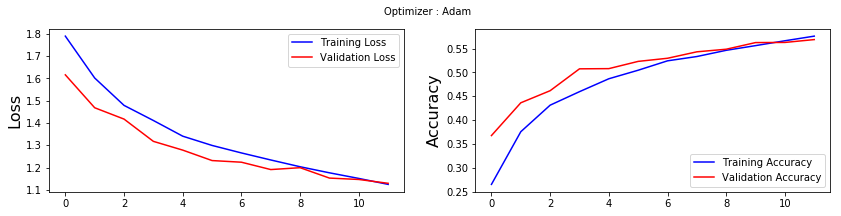

In [11]:
plt.figure(figsize=(14,3))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist.history['loss'], 'b', label='Training Loss')
plt.plot(hist.history['val_loss'], 'r', label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(hist.history['acc'], 'b', label='Training Accuracy')
plt.plot(hist.history['val_acc'], 'r', label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# conv_model.save()

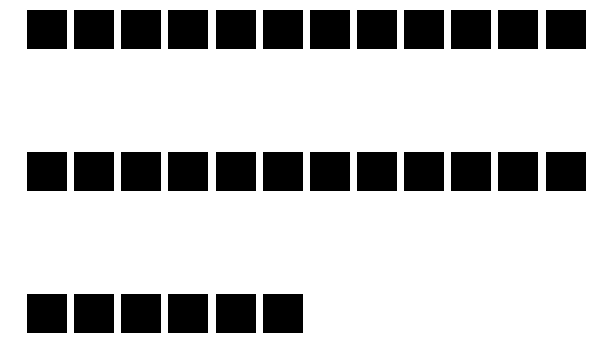

In [14]:
fig = plt.figure(figsize=(10,10))

for ix in range(30):
    ax = plt.subplot(4,12,ix+1)
    ax.set_title = ix
    plt.imshow(test[split+ix].reshape((48, 48)), cmap='gray')
    plt.axis('off')

In [15]:
pre = x_test[:100]
print pre.shape
ans = conv_model.predict(pre, batch_size=3)

correct=0
for ix in range(100):
    if np.argmax(ans[ix]) == np.argmax(y_test[ix]):
        #print np.argmax(ans[ix])," ",np.argmax(y_test[ix])
        correct += 1
        
print correct

(100, 1, 48, 48)
16


In [16]:
print ans.shape
print np.argmax(ans[10])
np.argmax(y_test[10])

(100, 7)
2


3

In [17]:
x_eval = x_test[343:3456]
y_eval = y[split+343:split+3456]
conv_model.evaluate_generator?
score = conv_model.evaluate(x_eval, y_eval, verbose=0) #, show_accuracy=True

In [34]:
print "Score : ", score[0]
print "Accuracy : ", score[1]*100

print score

Score :  1.1500677764894416
Accuracy :  56.0231288156056
[1.1500677764894416, 0.560231288156056]


In [43]:
conv_model1 = Sequential()

conv_model1.add(Convolution2D(64, (3, 3), activation='relu', input_shape=(1,48,48), data_format='channels_first'))
conv_model1.add(Convolution2D(64, (3, 3), activation='relu', data_format='channels_first'))
conv_model1.add(Convolution2D(64, (3, 3), activation='relu', data_format='channels_first'))
conv_model1.add(MaxPooling2D(pool_size=(2, 2), data_format='channels_first'))
conv_model1.add(Convolution2D(32, (3, 3), activation='relu', data_format='channels_first'))
conv_model1.add(Convolution2D(32, (3, 3), activation='relu', data_format='channels_first'))
conv_model1.add(Convolution2D(32, (3, 3), activation='relu', data_format='channels_first'))
conv_model1.add(MaxPooling2D(pool_size=(2, 2), data_format='channels_first'))
conv_model1.add(Dropout(0.5))

conv_model1.add(Flatten())
conv_model1.add(Dense(128, activation='relu'))
conv_model1.add(Dense(64, activation='relu'))
conv_model1.add(Dropout(0.5))
conv_model1.add(Dense(7))
conv_model1.add(Activation('softmax'))

conv_model1.summary()
#keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
conv_model1.compile(loss='categorical_crossentropy', optimizer='adam',
                  metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 64, 46, 46)        640       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 64, 44, 44)        36928     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 64, 42, 42)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 64, 21, 21)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 32, 19, 19)        18464     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 17, 17)        9248      
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 32, 15, 15)        9248      
__________

# Support Vector Machine
## Accuracy :

In [18]:
import sklearn
from sklearn import svm

In [19]:
#  Data Prep
X_train=x_train.reshape(len(x_train),48*48)
Y_train=np.argmax(y_train,axis=1)
X_test=x_test.reshape(len(x_test),48*48)
Y_test=np.argmax(y_test,axis=1)

In [ ]:
cf1 = svm.SVC(kernel='linear')
cf1.fit(X_train, Y_train)

print cf1.score(X_train, Y_train)
print cf1.score(X_test, Y_test)

In [ ]:
cf1 = svm.SVC(kernel='poly', random_state=21, degree=3)

cf1.fit(X_train, Y_train)
# TwoDim_dataset = dataset.reshape(dataset_size,-1)
print cf1.score(X_train, Y_train)
print cf1.score(X_test, Y_test)

In [ ]:
cf1 = svm.SVC(kernel='rbf')

cf1.fit(X_train, Y_train)

print cf1.score(X_train, Y_train)
print cf1.score(X_test, Y_test)

In [ ]:
import torchvision.models as models
vgg16 = models.vgg16(pretrained=True)
res=models.resnet101(pretrained=True)

In [ ]:
from keras import applications

In [ ]:
applications.vgg16??